# Introduction
Gaussian processes (henceforth GPs) achieve greater flexibility over parametric models by imposing a preference bias as opposed to restrictive constraints. Although the parameterisation of GPs allows one to access a certain (infinite) set of functions, preference can be expressed using a prior over functions. This allows greater freedom in representing data dependencies, thus enabling the construction of better-suited models. In this lab, we shall cover the basic concepts of GP regression. For the sake of clarity, we shall focus on univariate data, which enables better visualisation of the GP. Nonetheless, the code implemented within this lab can very easily be extended to handle multi-dimensional inputs.

In [236]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pprint import pprint
sns.set_style('whitegrid')
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

# Sampling from GP Prior
We shall consider a one-dimensional regression problem, whereby the inputs x are transformed by a function
f(x) = sin(exp(0.03 * x))

In [153]:
def f(x):
    x = np.asarray(x)
    return np.sin(np.exp(0.03 * x))

def plot(x, y, multiple_ys = False):
    plt.figure(figsize=[15, 10])
    if multiple_ys:
        for y_i in y:
            plt.scatter(x, y_i)
    else:
        plt.scatter(x, y)
    plt.xlabel('x', fontsize=15)
    plt.ylabel('y', fontsize=15)
    plt.show()

Generate 200 random points, x, in the range [-20, 80], and compute their corresponding function
values, t. The target function can then be plotted accordingly.

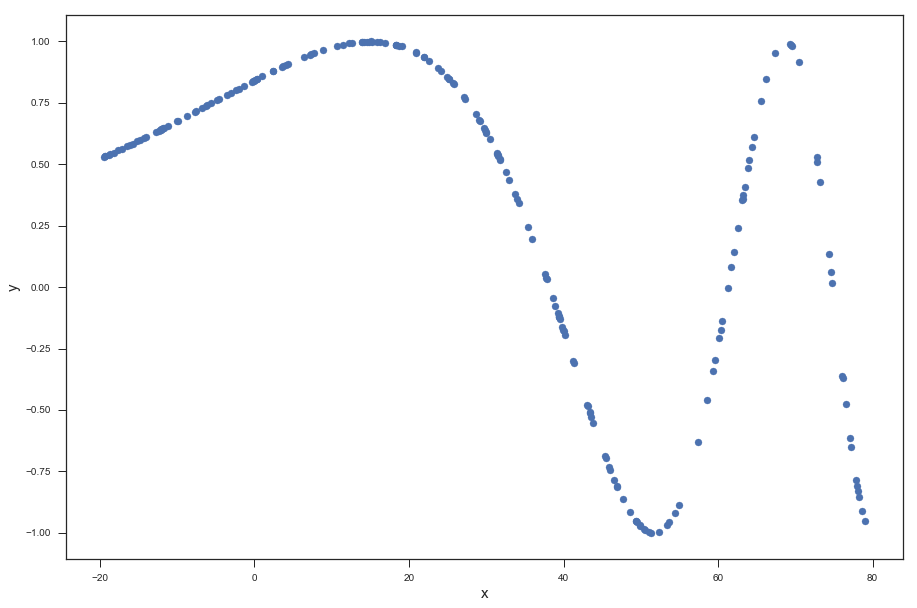

In [180]:
x = np.random.uniform(-20, 80, 200)
y = f(x)
plot(x, y)

Recall that since GPs are non-parametric, we define a prior distribution over functions (models),
specified as a multivariate Gaussian distribution
$$p(f) = N(μ,Σ).$$
Without loss of generality, we shall assume a zero-mean GP prior, i.e. $μ$ = 0. The covariance matrix of the distribution, Σ, may then be computed by evaluating the covariance between the input points. For this tutorial, we shall consider the widely used squared-exponential (RBF) covariance (also referred to as the kernel function), which is defined between two points as:
$$
k(x, x') = \sigma_f^2\exp\left(-\dfrac{(x-x')^2}{2l^2} \right)
$$
This kernel is parameterised by a lengthscale parameter l, and variance σf2. Given that the true function may be assumed to be corrupted with noise, we can also add a noise parameter, σn2, to the diagonal entries of the resulting kernel matrix, K, such that
$$
K = K + σ_n^2 I
$$

In [438]:
def RBF(x, x_prime, sigma=1, lenghtscale=1):
    x = np.asarray(x)
    x_prime = np.asarray(x_prime)
    return (sigma) * np.exp(-(np.linalg.norm(x-x_prime)**2)/(2*(lenghtscale**2)))

assert RBF(1, 1)==1, 'Wrong behaviour'

In [439]:
def compute_covariance_matrix(X, X_prime, sigma_f=1, lenghtscale=1, sigma_n=0):
    X = np.asarray(X)
    X_prime = np.asarray(X_prime)

    K = [[RBF(x, x_prime, sigma_f, lenghtscale) for x in X] for x_prime in X_prime]
    K = np.array(K)
    
    if sigma_n != 0:
        K = K + sigma_n*np.identity(K.shape[0])
    
    return K

Assuming a zero-mean prior, and using the kernel matrix constructed with compute kernel for input points x, we can sample from the prior distribution using the mvnrnd function as follows:

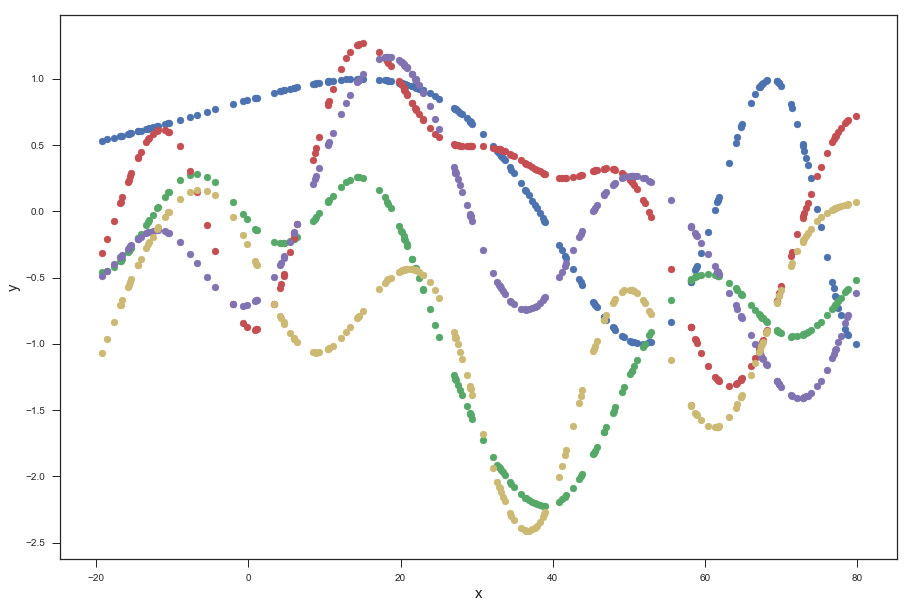

In [440]:
K = compute_covariance_matrix(x, x, lenghtscale=10, sigma_f=1, sigma_n=1e-6)
mu = np.zeros(x.shape)

y_1 = np.random.multivariate_normal(mu, K, 4)

plot(x, np.vstack([y, y_1]), multiple_ys=True)

On the same figure where we plotted the true function, draw four samples from the prior distri- bution and plot them accordingly. In order to better understand the role of the hyperparameters, observe how altering them impacts the shape of the prior samples.

In [ ]:
#TODO

# GP Inference

Recall that the prior represents our prior beliefs before observing the function values of any data points. Suppose we can now observe 3 points at random from the input data; we would expect that with this additional knowledge, the functions drawn from the updated GP distribution would be constrained to pass through these points (or at least close if corrupted with noise). The com- bination of the prior and the data leads to the posterior distribution over functions.

Assign 3 points at random from x (and their corresponding function values) to obs x and obs t respectively. We shall also package the kernel parameters as a list, params = [lengthscale, variance, noise]. You are encouraged to use the following initial configuration:
lengthscale = 10 variance = 2 noise = 1e-6

In [514]:
def gp_inference(obs_x, obs_y, new_x, sigma_f=1, sigma_n=1e-6, lenghtscale=1):
    
    K   = compute_covariance_matrix(obs_x, obs_x, sigma_f, lenghtscale, sigma_n)
    Kx  = compute_covariance_matrix(obs_x, new_x, sigma_f, lenghtscale)
    Kxx = compute_covariance_matrix(new_x, new_x, sigma_f, lenghtscale)
    
    L = scipy.linalg.cholesky(K)
    B = scipy.linalg.solve_triangular(L, obs_y, lower=True)
    alpha = scipy.linalg.solve_triangular(L.T, B, lower=False)
    v = np.dot(Kx, np.linalg.inv(L))
    
    post_mean_y = Kx.dot(alpha)
    post_variance_y = Kxx - np.dot(v, v.T)#Kx.dot(inverse_product(K, Kx.T))
    
    nll = -0.5 * obs_y.dot(alpha) - L.trace()

    return (post_mean_y, post_variance_y, nll)

In [536]:
obs_x = np.random.choice(x, 3, replace=False)
obs_y = f(obs_x)
x_new = np.arange(-20, 80, 0.5)
post_mean, post_var, nll = gp_inference(obs_x, obs_y, x_new, sigma_f=2, lenghtscale=10, sigma_n=1e-7)
print(nll)

()
-4.8232669685


/Users/Simone/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  from ipykernel import kernelapp as app


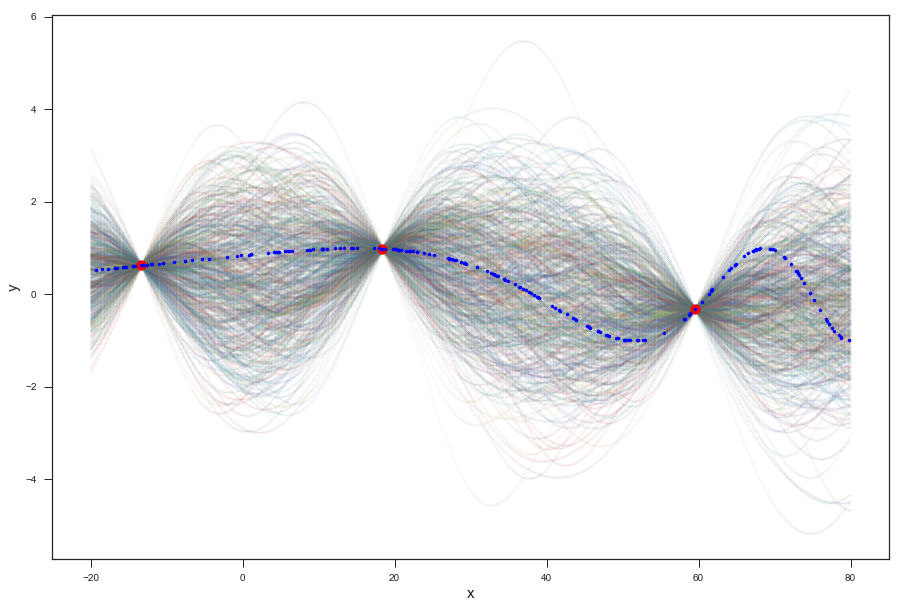

In [510]:
plt.figure(figsize=[15, 10])
post_y = np.random.multivariate_normal(post_mean, post_var, 500)
#plot(x_new, post_y, multiple_ys=True)
plt.figure(figsize=[15, 10])

for y_i in post_y:
    plt.scatter(x_new, y_i, s=3, alpha=.05)

plt.scatter(obs_x,obs_y, s=100, color='red')
plt.scatter(x, y, s=10, color='blue')

plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.show()

In [524]:
x_new = np.arange(-20, 80, 0.5)
_, _, nll = gp_inference(obs_x, obs_y, x_new, sigma_f=2, lenghtscale=10, sigma_n=1e-7)

()


In [526]:
print(nll)

-4.07718010779
